In [1]:
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import numpy as np
import utility as ut
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import seaborn as sns
import oneshot as sm
import surrogate as sr 
import torch
from torch import nn
import eulerN as arch 

Time taken by sample is 0.0159 seconds
Time taken by sample is 0.0112 seconds


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1001 is different from 2)

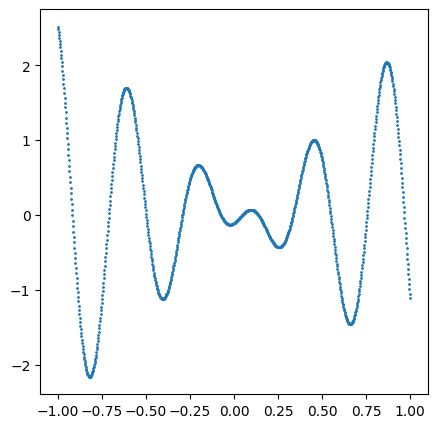

In [3]:
description = "This experiment checks deep RFM vs RFM for a function approximation task. The function used here is tasmania(x) = 0.03 - (1.4 - 2.5*(x+0.5)) * np.sin(15*(x+0.5))."
experimentFolder = '../data/RFM-vs-DeepRFM-tasmania'
ut.makeDir(experimentFolder)

tasmania = lambda x: 0.03 - (1.4 - 2.5*(x+0.5)) * np.sin(15*(x+0.5))
a, b = -1, 1.
x = np.linspace(a, b, num=1000)

test_x = np.random.uniform(a, b, size=(1, 1000))
test_y = tasmania(test_x)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.scatter(x, tasmania(x), s=1, label="data")

L0, L1, D, D_r, beta, N, B = 0.4, 3.5, 1, 300, 4e-5, 20000, 5
Uo = x.reshape(-1, 1).T
sampler = sm.MatrixSampler(L0, L1, Uo)


goodWb = sampler.sample_([D_r, 0, 0])
goodRFM = sr.SurrogateModel_LR(D=D, D_r=D_r, W_in_fn=goodWb[:, :-1], b_in_fn=goodWb[:, -1], name="Good RFM")
goodRFM.compute_W_xy(Uo, tasmania(Uo), beta)
goodRFM.validation_error(test_x, test_y)


eulerNRFM = arch.DeepRF(D_r, B, L0, L1, Uo, beta, name=f'EulerN Depth {B}', save_folder=experimentFolder)
eulerNRFM.init_xy(Uo, tasmania(Uo))
eulerNRFM.validation_error(test_x, test_y)

ax.plot(x, goodRFM.forecast_m(Uo).flatten(), label=f"{goodRFM.name}")
ax.plot(x, eulerNRFM.forecast_m(Uo).flatten(), label=f"{eulerNRFM.name}")
ax.legend()

expLogger = ut.ExperimentLogger(experimentFolder, description)
expLogger.add(saturatedRFM, goodRFM, uniformRFM)

plt.savefig(f"{experimentFolder}/fit_beta_{beta}.png")

Time taken by sample is 0.0053 seconds
Time taken by sample is 0.0051 seconds


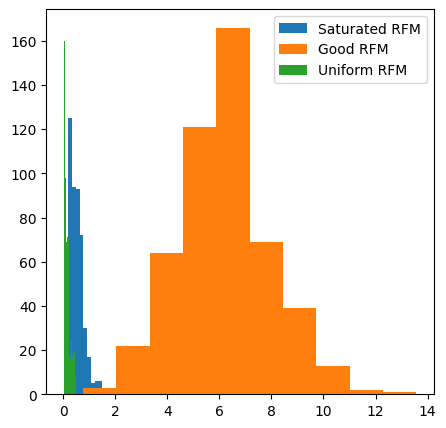

In [39]:
description = "This experiment checks the forecast times for p_g=0, 1 and uniformly sampled RFMs for L63."
experimentFolder = '../data/pg-0-1-uniform-L63'
ut.makeDir(experimentFolder)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

L0, L1, D, D_r, beta, N = 0.4, 3.5, 3, 300, 4e-5, 20000
L63_data_folder = '../data/L63-trajectories'
Uo = np.load('{}/train.npy'.format(L63_data_folder))[:N]
test = np.load('{}/test.npy'.format(L63_data_folder))[:, :800, :]
sampler = sm.MatrixSampler(L0, L1, Uo)


saturatedWb = sampler.sample_([0, 0, D_r])
saturatedRFM = sr.SurrogateModel_LR(D=D, D_r=D_r, W_in_fn=saturatedWb[:, :-1], b_in_fn=saturatedWb[:, -1], name="Saturated RFM")
saturatedRFM.compute_W(Uo, beta)
saturatedTau_f = saturatedRFM.compute_forecast_time(test[:500], 0.05, 0.02)[0]

goodWb = sampler.sample_([D_r, 0, 0])
goodRFM = sr.SurrogateModel_LR(D=D, D_r=D_r, W_in_fn=goodWb[:, :-1], b_in_fn=goodWb[:, -1], name="Good RFM")
goodRFM.compute_W(Uo, beta)
goodTau_f = goodRFM.compute_forecast_time(test[:500], 0.05, 0.02)[0]

uniformWb = np.random.uniform([-5., -5., -5., -2.], [5., 5., 5., 2.], size=(D_r, D+1))
uniformRFM = sr.SurrogateModel_LR(D=D, D_r=D_r, W_in_fn=uniformWb[:, :-1], b_in_fn=uniformWb[:, -1], name="Uniform RFM")
uniformRFM.compute_W(Uo, beta)
uniformTau_f = uniformRFM.compute_forecast_time(test[:500], 0.05, 0.02)[0]

ax.hist(saturatedTau_f, label=f"{saturatedRFM.name}")
ax.hist(goodTau_f, label=f"{goodRFM.name}")
ax.hist(uniformTau_f, label=f"{uniformRFM.name}")
ax.legend()

expLogger = ut.ExperimentLogger(experimentFolder, description)
expLogger.add(saturatedRFM, goodRFM, uniformRFM)

plt.savefig(f"{experimentFolder}/tau_f_beta_{beta}.png")